<a href="https://colab.research.google.com/github/Pugianf/Big_Data_and_Public_Sector_II/blob/main/Trabalho_Final_Big_Data_e_Setor_P%C3%BAblico_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Questão 1

### 1.1 - Leitura dos Dados

In [156]:
# intalando as bibliotecas necessárias

!pip install statsmodels
!pip install linearmodels
!pip unintall scipy
!pip install --upgrade scipy

from IPython.display import clear_output 

clear_output()

In [157]:
# importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
from linearmodels.iv import IV2SLS
from IPython.display import clear_output 

In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
# módulos de teste

from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from patsy import dmatrices

In [160]:
# lendo os dados e criando o DataFrame

df = pd.read_stata('/content/drive/MyDrive/IDP/Dataset/evaluation.dta')

In [161]:
# visualizando o shape da base de dados

df.shape

(19827, 22)

In [162]:
# primeira vista da base de dados

df.head(10)

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
0,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
1,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
2,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0
3,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0
4,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0
5,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,0.0,15.286353,58.0,56.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,0.0
6,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,1.0,20.026909,36.0,25.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
7,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,0.0,11.311761,35.0,24.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
8,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,0.0,11.223912,37.0,35.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
9,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,1.0,16.664686,39.0,36.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0


In [163]:
# vendo a descrição das variáveis (só funciona com arquivos .dta)

# lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader

stata_reader = pd.read_stata('/content/drive/MyDrive/IDP/Dataset/evaluation.dta', iterator=True)

# pegando as descrições das variáveis

descricoes = stata_reader.variable_labels()

descricoes

{'age_hh': 'Age of the head of the household (in years)',
 'age_sp': 'Age of the spouse (in years)',
 'bathroom': 'Home with private bathroom at baseline (0=no, 1=yes)',
 'dirtfloor': 'Home has a dirt floor at baseline (0=no, 1=yes)',
 'educ_hh': 'Education of the head of household (completed years of schooling)',
 'educ_sp': 'Education of the spouse (completed years of schooling)',
 'eligible': 'Household eligible to enroll in HISP (0=no, 1=yes)',
 'enrolled': 'HH enrolled in HISP (0=no, 1=yes)',
 'enrolled_rp': 'Household enrolled in HISP under the random promotion scenario (0=no, 1=yes)',
 'female_hh': 'Head of the household is a woman (0=no, 1=yes)',
 'health_expenditures': 'Out of pocket health expenditures (per person per year)',
 'hhsize': 'Number of household members (baseline)',
 'hospital': 'HH member visited hospital in the past year (0=no, 1=yes)',
 'hospital_distance': 'Distance to closest hospital',
 'household_identifier': 'Unique household identifier',
 'indigenous': 'H

In [164]:
# descrevendo o DataFrame

df.describe()

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
count,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,11257.000000
mean,73.933472,8038.965820,0.500277,0.512685,0.567761,0.299037,0.293287,56.789505,0.500025,17.035103,46.683117,40.581734,2.833550,2.618601,0.099057,0.352903,5.178645,0.603621,0.615978,2.079740,105.322517,0.052323
std,55.076599,4569.468262,0.500017,0.499851,0.495377,0.457822,0.455238,10.686106,0.500013,9.291589,15.294811,12.822810,2.754772,2.543370,0.298730,0.477869,2.195178,0.489157,0.486375,3.133202,42.063479,0.222696
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.479134,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.465392,0.000000
25%,30.000000,3989.500000,0.000000,0.000000,0.000000,0.000000,0.000000,49.652241,0.000000,11.621977,34.000000,31.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,72.804218,0.000000
50%,59.000000,8040.000000,1.000000,1.000000,1.000000,0.000000,0.000000,56.414219,1.000000,16.051678,45.000000,41.000000,2.000000,2.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,113.556497,0.000000
75%,112.000000,12033.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.905720,1.000000,21.236842,58.000000,48.000000,4.000000,4.000000,0.000000,1.000000,7.000000,1.000000,1.000000,3.000000,141.097735,0.000000
max,200.000000,15778.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,116.830643,88.000000,88.000000,16.000000,17.000000,1.000000,1.000000,13.000000,1.000000,1.000000,23.000000,170.457647,1.000000


### 1.2 - Divisão de antes e depois do programa

In [165]:
# dividindo de antes do programa

df_inscritos_antes = df.query('enrolled == 1 & round == 0 & treatment_locality == 1')

df_inscritos_antes

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
0,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
2,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0
5,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,0.0,15.286353,58.0,56.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,0.0
7,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,0.0,11.311761,35.0,24.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
8,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,0.0,11.223912,37.0,35.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11247,40.0,15773.0,1.0,1.0,1.0,1.0,1.0,28.979908,0.0,7.218568,57.0,51.0,3.0,0.0,0.0,1.0,9.0,1,1,1,114.763392,0.0
11249,40.0,15774.0,1.0,1.0,1.0,1.0,1.0,28.593508,0.0,7.241524,53.0,53.0,5.0,0.0,0.0,1.0,9.0,1,1,2,114.763392,0.0
11252,40.0,15775.0,1.0,1.0,1.0,1.0,1.0,37.171562,0.0,10.391406,29.0,27.0,1.0,6.0,0.0,1.0,6.0,1,1,0,114.763392,0.0
11253,40.0,15776.0,1.0,1.0,1.0,1.0,1.0,29.057186,0.0,8.679602,78.0,41.0,0.0,2.0,0.0,1.0,9.0,1,0,0,114.763392,0.0


In [166]:
# dados de depois do programa

df_inscritos_depois = df.query('enrolled == 1 & round == 1')

df_inscritos_depois

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
1,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
3,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0
4,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0
6,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,1.0,20.026909,36.0,25.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
9,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,1.0,16.664686,39.0,36.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11248,40.0,15773.0,1.0,1.0,1.0,1.0,1.0,28.979908,1.0,0.000000,58.0,52.0,3.0,0.0,0.0,1.0,9.0,1,1,1,114.763392,0.0
11250,40.0,15774.0,1.0,1.0,1.0,1.0,1.0,28.593508,1.0,7.193629,54.0,54.0,5.0,0.0,0.0,1.0,9.0,1,1,2,114.763392,0.0
11251,40.0,15775.0,1.0,1.0,1.0,1.0,1.0,37.171562,1.0,0.727366,30.0,28.0,1.0,6.0,0.0,1.0,6.0,1,1,0,114.763392,0.0
11254,40.0,15776.0,1.0,1.0,1.0,1.0,1.0,29.057186,1.0,0.000000,79.0,41.0,0.0,2.0,0.0,1.0,9.0,1,0,0,114.763392,0.0


In [167]:
# dados de todos os inscritos no programa

df_inscritos = df.query('enrolled == 1')

df_inscritos

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
0,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
1,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
2,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0
3,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0
4,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11252,40.0,15775.0,1.0,1.0,1.0,1.0,1.0,37.171562,0.0,10.391406,29.0,27.0,1.0,6.0,0.0,1.0,6.0,1,1,0,114.763392,0.0
11253,40.0,15776.0,1.0,1.0,1.0,1.0,1.0,29.057186,0.0,8.679602,78.0,41.0,0.0,2.0,0.0,1.0,9.0,1,0,0,114.763392,0.0
11254,40.0,15776.0,1.0,1.0,1.0,1.0,1.0,29.057186,1.0,0.000000,79.0,41.0,0.0,2.0,0.0,1.0,9.0,1,0,0,114.763392,0.0
11255,40.0,15777.0,1.0,1.0,1.0,1.0,1.0,38.485317,1.0,0.000000,32.0,26.0,4.0,2.0,0.0,1.0,6.0,1,0,0,114.763392,0.0


### 1.3 - Comparação de gastos médios

In [168]:
# realizando testes:

stats.ttest_ind(df_inscritos_antes['health_expenditures'], df_inscritos_depois['health_expenditures'], nan_policy='omit')

# o p-value é muito baixo, então rejeita-se a hipótese de que a média de gastos depois do programa é igual à de antes

Ttest_indResult(statistic=39.764560411867826, pvalue=9.90593763905028e-307)

## Questão 2

### 2.1 - Comparação das médias de antes e depois dos gastos com saúde

In [169]:
# média total

df['health_expenditures'].mean()

17.03510284423828

In [170]:
# média dos inscritos

df_inscritos['health_expenditures'].mean()

11.164377212524414

In [171]:
# média de antes

df_inscritos_antes['health_expenditures'].mean()

14.489691734313965

In [172]:
# desvio padrão de antes

statistics.stdev(df_inscritos_antes['health_expenditures'])

4.356316817636983

In [173]:
# intervalo de confiança

stats.norm.interval(alpha=0.95, loc=np.mean(df_inscritos_antes['health_expenditures']), scale=stats.sem(df_inscritos_antes['health_expenditures']))

(14.332861994093571, 14.646521474534358)

In [174]:
# média de depois

df_inscritos_depois['health_expenditures'].mean()

7.840174198150635

### 2.2 - Regressões

In [175]:
# regressão simples

formula_simples = "health_expenditures ~ 1 + round"

modelo_simples_antesdepois = ols(formula_simples, df_inscritos).fit(cov_type="HC2", use_t=True)

print(modelo_simples_antesdepois.summary())

# se pode deduzir que, com o passar do tempo, os gastos (em dólares por pessoa por ano) cairam $6,65

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.211
Model:                             OLS   Adj. R-squared:                  0.210
Method:                  Least Squares   F-statistic:                     1582.
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):          8.84e-307
Time:                         23:04:08   Log-Likelihood:                -19453.
No. Observations:                 5929   AIC:                         3.891e+04
Df Residuals:                     5927   BIC:                         3.892e+04
Df Model:                            1                                         
Covariance Type:                   HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.4897      0.080    181.08

In [176]:
# regressão com modelo mais completo

formula_completa = "health_expenditures ~ 1 + round + age_hh +  educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"

modelo_completo_antesdepois = ols(formula_completa, df_inscritos).fit(cov_type="HC2", use_t=True)

print(modelo_completo_antesdepois.summary())

# o resultado é muito similar e com a mesma conclusão do modelo mais simples

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.483
Model:                             OLS   Adj. R-squared:                  0.482
Method:                  Least Squares   F-statistic:                     783.6
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):               0.00
Time:                         23:04:08   Log-Likelihood:                -18201.
No. Observations:                 5929   AIC:                         3.643e+04
Df Residuals:                     5917   BIC:                         3.651e+04
Df Model:                           11                                         
Covariance Type:                   HC2                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            24.7391

## Questão 3

### 3.1 -Comparação dos gastos de saúde da linha de base e outras covariáveis

In [177]:
# comparação de diferentes médias entre elegíveis em comunidades de tratamento e controle

df[df.eligible == 1].groupby('treatment_locality')[["health_expenditures", "age_hh", "age_sp", "educ_hh", "educ_sp", "female_hh", "indigenous",
              "hhsize", "dirtfloor", "bathroom", "land", "hospital_distance"]].mean()

# as médias da amostra permitem supor uma devida randomização, conforme esperado, já que se trata do esperado para aplicação da política pública

,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance
treatment_locality,,,,,,,,,,,,
0.0,16.277199,42.773087,37.293919,2.811321,2.675676,0.077327,0.420045,5.710210,0.734610,0.558559,1.717342,106.295549
1.0,11.164376,42.141880,37.237476,2.971185,2.705009,0.073200,0.429246,5.770113,0.721538,0.573621,1.678023,109.213428


In [178]:
# criando lista e fórmula com controles

# lista
lControles = ["age_hh", "age_sp", "educ_hh", "educ_sp", "female_hh", "indigenous", "hhsize", "dirtfloor", "bathroom", "land", "hospital_distance"]

# ormulas
sControles = "age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"

In [179]:
# pegando apenas os elegíveis (não necessariamente que participaram!)

dfElegiveis = df.query('eligible == 1')

# criando os DataFrames

dfTratamento = dfElegiveis.query('treatment_locality == 1 & round == 0')

dfComparacao = dfElegiveis.query('treatment_locality == 0 & round == 0')

In [180]:
# realizando os testes

for sVariavel in lControles:
  tuplaTeste = stats.ttest_ind(dfTratamento[sVariavel], 
                               dfComparacao[sVariavel], 
                               nan_policy='omit', alternative='two-sided')
  
# vendo se a diferença é significante
  
  sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# printando ([0]=estatística; [1]=p-valor)

  print(f"\n========================= {sVariavel}{sAsterisco} =========================")
  print(f"Média Tratamento: {np.around(dfTratamento[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 2)}")
  print(f"Diferença = {np.around(dfTratamento[sVariavel].mean() - dfComparacao[sVariavel].mean(), 2)}")
  print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

# nesse teste, a única variável significante que auxilía na explicação dos gastos de saúde seria a distância do hospital


========================= age_hh =========================
Média Tratamento: 41.66 	 Média Comparação: 42.29
Diferença = -0.64
Estatística = -1.6948 	 P-valor = 0.0902

========================= age_sp =========================
Média Tratamento: 36.84 	 Média Comparação: 36.88
Diferença = -0.04
Estatística = -0.1238 	 P-valor = 0.9015

========================= educ_hh** =========================
Média Tratamento: 2.97 	 Média Comparação: 2.81
Diferença = 0.16
Estatística = 2.302 	 P-valor = 0.0214

========================= educ_sp =========================
Média Tratamento: 2.7 	 Média Comparação: 2.67
Diferença = 0.03
Estatística = 0.4321 	 P-valor = 0.6657

========================= female_hh =========================
Média Tratamento: 0.07 	 Média Comparação: 0.08
Diferença = -0.0
Estatística = -0.5846 	 P-valor = 0.5588

========================= indigenous =========================
Média Tratamento: 0.43 	 Média Comparação: 0.42
Diferença = 0.01
Estatística = 0.6898 	 P-valor =

### 3.2 - Comparação dos gastos com saúde para a população elegível em tratamento e comunidades de controle

In [181]:
# mesmo com uma diferença significativa e hipoteticamente esperada, não se pode afirmar que esta diferença total se trata apenas do programa

df[(df['round'] == 1) & (df['eligible'] == 1)].groupby('treatment_locality')[['health_expenditures']].mean()

,health_expenditures
treatment_locality,
0.0,17.980551
1.0,7.840179


In [182]:
# filtrando o df para round 1

dfTratamento = dfElegiveis.query('treatment_locality == 1 & round == 1')

dfComparacao = dfElegiveis.query('treatment_locality == 0 & round == 1')

# relativo aos gastos com saúde

sVariavel = "health_expenditures"

# realização do teste

tuplaTeste = stats.ttest_ind(dfTratamento[sVariavel], 
                              dfComparacao[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

# vendo se a diferença é significante

sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# printando ([0]=estatística; [1]=p-valor)

print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Tratamento: {np.around(dfTratamento[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 2)}")
print(f"Diferença = {np.around(dfTratamento[sVariavel].mean() - dfComparacao[sVariavel].mean(), 2)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

# nota-se um p-value extremamente significante, confirmando o resultado da política pública

========================= health_expenditures** =========================
Média Tratamento: 7.84 	 Média Comparação: 17.98
Diferença = -10.14
Estatística = -49.151 	 P-valor = 0.0


### 3.3 - Regressão OLS

In [183]:
# elegíveis no round 0 (mesmos resultados do teste anterior)

formula_simples = "health_expenditures ~ 1 + treatment_locality"

# fittando com covariância CLUSTERIZADA

modelo_simples_antes = ols(formula_simples, dfElegiveis.query('round == 0')).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis.query('round == 0')["locality_identifier"]})

print(modelo_simples_antes.summary())

# R2, estatística F ruins: realmente domicílios antes eram semelhantes

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.1559
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):              0.693
Time:                         23:04:08   Log-Likelihood:                -16195.
No. Observations:                 5628   AIC:                         3.239e+04
Df Residuals:                     5626   BIC:                         3.241e+04
Df Model:                            1                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.5

In [184]:
# elegíveis no round 1

modelo_simples_depois = ols(formula_simples, dfElegiveis.query('round == 1')).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis.query('round == 1')["locality_identifier"]})

print(modelo_simples_depois.summary())

# localidades diferentes após o programa passam a ter grandes diferenças

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.300
Model:                             OLS   Adj. R-squared:                  0.300
Method:                  Least Squares   F-statistic:                     656.8
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):           1.70e-64
Time:                         23:04:08   Log-Likelihood:                -19497.
No. Observations:                 5629   AIC:                         3.900e+04
Df Residuals:                     5627   BIC:                         3.901e+04
Df Model:                            1                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.9

In [185]:
# regressão múltipla

formula_multipla = f"{formula_simples} + {sControles}"

modelo_multiplo_depois = ols(formula_multipla, dfElegiveis.query('round == 1')).fit(
    use_t=True, 
    cov_type='cluster', 
    cov_kwds={'groups': dfElegiveis.query('round == 1')["locality_identifier"]}
)

print(modelo_multiplo_depois.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.430
Model:                             OLS   Adj. R-squared:                  0.428
Method:                  Least Squares   F-statistic:                     136.0
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):           4.78e-88
Time:                         23:04:08   Log-Likelihood:                -18922.
No. Observations:                 5629   AIC:                         3.787e+04
Df Residuals:                     5616   BIC:                         3.796e+04
Df Model:                           12                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.5

In [186]:
# questão 4

# pode-se deduzir do modelo uma diferença percentual de aproximadamente 10% entre as famílias tratadas e não tratadas

# conclui-se que o programa possui impacto positivo para aqueles que recebem o tratamento

In [187]:
# questão 5

# ainda existe o risco de haver ocorrido um cumprimento parcial, ou seja:
  ## que algumas das unidades selecionadas para o grupo de tratamento optaram por não se inscrever ou foram deixadas sem tratamento, ou
  ## alguns indivíduos selecionados para o grupo de comparação conseguiram participar do programa.

## Questão 4

### 4.1 - Regressão OLS

In [188]:
# criando os DataFrames

dfPromovido = df.query('promotion_locality == 1 & round == 0')

dfComparacao = df.query('promotion_locality == 0 & round == 0')

for sVariavel in lControles:
  tuplaTeste = stats.ttest_ind(dfPromovido[sVariavel], 
                               dfComparacao[sVariavel], 
                               nan_policy='omit', alternative='two-sided')
  
  sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

  print(f"\n========================= {sVariavel}{sAsterisco} =========================")
  print(f"Média Promoção: {np.around(dfPromovido[sVariavel].mean(), 2)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 2)}")
  print(f"Diferença = {np.around(dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean(), 2)}")
  print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

# as características entre as vilas promovidas ou não parecem ser diferentes


========================= age_hh** =========================
Média Promoção: 45.79 	 Média Comparação: 46.63
Diferença = -0.84
Estatística = -2.7262 	 P-valor = 0.0064

========================= age_sp** =========================
Média Promoção: 39.79 	 Média Comparação: 40.6
Diferença = -0.8
Estatística = -3.1324 	 P-valor = 0.0017

========================= educ_hh** =========================
Média Promoção: 2.77 	 Média Comparação: 2.9
Diferença = -0.14
Estatística = -2.4669 	 P-valor = 0.0136

========================= educ_sp** =========================
Média Promoção: 2.56 	 Média Comparação: 2.68
Diferença = -0.12
Estatística = -2.3038 	 P-valor = 0.0213

========================= female_hh =========================
Média Promoção: 0.1 	 Média Comparação: 0.1
Diferença = 0.0
Estatística = 0.0382 	 P-valor = 0.9695

========================= indigenous** =========================
Média Promoção: 0.32 	 Média Comparação: 0.39
Diferença = -0.07
Estatística = -7.6871 	 P-valor = 0.

In [189]:
# sobre os gastos com saúde

sVariavel = "health_expenditures"

# Fazendo o teste

tuplaTeste = stats.ttest_ind(dfPromovido[sVariavel], 
                              dfComparacao[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

# printando ([0]=estatística; [1]=p-valor)

print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Promoção: {np.around(dfPromovido[sVariavel].mean(), 4)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 4)}")
print(f"Diferença = {np.around(dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean(), 4)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

# apesar das características serem diferentes, os gastos com saúde são similares

========================= health_expenditures =========================
Média Promoção: 17.1853 	 Média Comparação: 17.238
Diferença = -0.0526
Estatística = -0.4684 	 P-valor = 0.6395


In [190]:
# fazendo a regressão:

formula_base = "health_expenditures ~ 1 + promotion_locality"

modelo_base = ols(data=df.query('round == 0'), formula=formula_base).fit(cov_type='HC2')

print(modelo_base.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.2191
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):              0.640
Time:                         23:04:09   Log-Likelihood:                -31122.
No. Observations:                 9913   AIC:                         6.225e+04
Df Residuals:                     9911   BIC:                         6.226e+04
Df Model:                            1                                         
Covariance Type:                   HC2                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.2

In [191]:
# participação efetiva com promoção aleatória

sVariavel = "enrolled_rp"

# teste

tuplaTeste = stats.ttest_ind(dfPromovido[sVariavel], 
                              dfComparacao[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Promoção: {np.around(dfPromovido[sVariavel].mean(), 3)} \t Média Comparação: {np.around(dfComparacao[sVariavel].mean(), 3)}")
print(f"Diferença = {np.around(dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean(), 3)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

nParticipaEncorojado = dfPromovido[sVariavel].mean() - dfComparacao[sVariavel].mean()

# a promoção foi boa em incentivar a adesão ao HISP, com uma diferença de 40,8%

========================= enrolled_rp** =========================
Média Promoção: 0.492 	 Média Comparação: 0.084
Diferença = 0.408
Estatística = 49.8326 	 P-valor = 0.0


In [192]:
# diferença nos gastos com saúde das vilas promocionadas APÓS o HISP

# criando os DataFrames

dfPromovido1 = df.query('promotion_locality == 1 & round == 1')

dfComparacao1 = df.query('promotion_locality == 0 & round == 1')

sVariavel = "health_expenditures"

tuplaTeste = stats.ttest_ind(dfPromovido1[sVariavel], 
                              dfComparacao1[sVariavel], 
                              nan_policy='omit', alternative='two-sided')

sAsterisco = "**" if tuplaTeste[1] < 0.05 else ""

print(f"========================= {sVariavel}{sAsterisco} =========================")
print(f"Média Promoção: {np.around(dfPromovido1[sVariavel].mean(), 4)} \t Média Comparação: {np.around(dfComparacao1[sVariavel].mean(), 4)}")
print(f"Diferença = {np.around(dfPromovido1[sVariavel].mean() - dfComparacao1[sVariavel].mean(), 4)}")
print(f"Estatística = {np.around(tuplaTeste[0], 4)} \t P-valor = {np.around(tuplaTeste[1], 4)}")

========================= health_expenditures** =========================
Média Promoção: 14.9715 	 Média Comparação: 18.8454
Diferença = -3.8738
Estatística = -16.433 	 P-valor = 0.0


In [193]:
# pode-se ter uma primeira estimativa do LATE dividindo a diferença anterior pela porcentagem da população no grupo "participa se encorajado"

nDiferencaPromocao = (dfPromovido1[sVariavel].mean() - dfComparacao1[sVariavel].mean()) / nParticipaEncorojado

nDiferencaPromocao

# a primeira estimativa é que o programa conseguiu reduzir em US$ 9,5 (por pessoa por ano) nos gastos com saúde do grupo que participa se for encorajado

# é importante se ressaltar que o resultado não pode ser extrapolado para os demais

-9.502065361089176

### 4.2 - Mínimos Quadrados de Dois Estágios

In [194]:
# fazendo o modelo inicial

dfRound0 = df.query('round == 0')

dfRound1 = df.query('round == 1')

# modelo

formula_vi_primeiro_estagio = "enrolled_rp ~ 1 + promotion_locality"

modelo_vi_primeiro_estagio = IV2SLS.from_formula(formula=formula_vi_primeiro_estagio, data=dfRound1).fit()

print(modelo_vi_primeiro_estagio.summary)

                            OLS Estimation Summary                            
Dep. Variable:            enrolled_rp   R-squared:                      0.2004
Estimator:                        OLS   Adj. R-squared:                 0.2003
No. Observations:                9914   F-statistic:                    2552.8
Date:                Fri, Jan 21 2022   P-value (F-stat)                0.0000
Time:                        23:04:09   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Intercept              0.0842     0.0040     21.082     0.0000      0.0764      0.0921
promotion_locality  

In [195]:
# adicionando os valores fittados e adicionando

dfRound1['enrolled_rp_vi'] = modelo_vi_primeiro_estagio.fitted_values

dfRound1['enrolled_rp_vi']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1        0.492032
3        0.492032
4        0.492032
6        0.492032
9        0.492032
           ...   
19817    0.084248
19819    0.084248
19821    0.084248
19824    0.492032
19826    0.492032
Name: enrolled_rp_vi, Length: 9914, dtype: float64

In [196]:
# usando esses valores pra fittar o novo modelo

formula_vi_segundo_estagio = "health_expenditures ~ 1 + enrolled_rp_vi"

modelo_vi_segundo_estagio = IV2SLS.from_formula(formula=formula_vi_segundo_estagio, data=dfRound1).fit()

print(modelo_vi_segundo_estagio.summary)

# diferença de US$ -9,49, assim como visto na análise de médias

                             OLS Estimation Summary                            
Dep. Variable:     health_expenditures   R-squared:                      0.0265
Estimator:                         OLS   Adj. R-squared:                 0.0264
No. Observations:                 9914   F-statistic:                    272.09
Date:                 Fri, Jan 21 2022   P-value (F-stat)                0.0000
Time:                         23:04:09   Distribution:                  chi2(1)
Cov. Estimator:                 robust                                         
                                                                               
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          19.646     0.1915     102.60     0.0000      19.270      20.021
enrolled_rp_vi    -9.4998   

In [197]:
# criando o modelo diretamente

formula_vi_simples = "health_expenditures ~ 1 + [enrolled_rp ~ promotion_locality]"

modelo_vi_simples = IV2SLS.from_formula(formula=formula_vi_simples, data=dfRound1).fit()

print(modelo_vi_simples.summary)

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.2217
Estimator:                     IV-2SLS   Adj. R-squared:                 0.2216
No. Observations:                 9914   F-statistic:                    338.60
Date:                 Fri, Jan 21 2022   P-value (F-stat)                0.0000
Time:                         23:04:09   Distribution:                  chi2(1)
Cov. Estimator:                 robust                                         
                                                                               
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       19.646     0.1806     108.76     0.0000      19.292      20.000
enrolled_rp    -9.4998     0.5163    -18

In [198]:
# modelo mais completo e com covariâancia clusterizada

formula_vi = f"{formula_vi_simples} + {sControles}"

modelo_vi = IV2SLS.from_formula(formula=formula_vi, data=dfRound1).fit(
  cov_type='clustered',  # note o -ED no final
  clusters=dfRound1["locality_identifier"])

print(modelo_vi.summary)

# efeito mais preciso: $-9.74 (dólares por pessoa por ano)

# o efeito muda mais em virtude do fato de as vilas promovidas serem um pouco distintas em suas características observáveis daquelas que não foram promovidas

                           IV-2SLS Estimation Summary                          
Dep. Variable:     health_expenditures   R-squared:                      0.4057
Estimator:                     IV-2SLS   Adj. R-squared:                 0.4049
No. Observations:                 9914   F-statistic:                    2414.3
Date:                 Fri, Jan 21 2022   P-value (F-stat)                0.0000
Time:                         23:04:09   Distribution:                 chi2(12)
Cov. Estimator:              clustered                                         
                                                                               
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             29.168     0.8355     34.912     0.0000      27.531      30.806
age_hh          

## Questão 5

### 5.1 - Regressão OLS

In [199]:
# selecionando apenas os dados relevantes

dfTratados = df.query('treatment_locality == 1').copy()

In [200]:
nPobreza = 58

# domicílios pobres

dfTratados['pobre'] = np.where(dfTratados['poverty_index'] <= nPobreza, 1, 0)

# normalização

dfTratados['poverty_index_norm'] = dfTratados['poverty_index'] - nPobreza

# resultados

dfTratados[['poverty_index', 'pobre', 'poverty_index_norm', 'eligible']]

,poverty_index,pobre,poverty_index_norm,eligible
0,55.950542,1,-2.049458,1.0
1,55.950542,1,-2.049458,1.0
2,46.058731,1,-11.941269,1.0
3,46.058731,1,-11.941269,1.0
4,54.095825,1,-3.904175,1.0
...,...,...,...,...
19778,66.846985,0,8.846985,0.0
19823,62.055641,0,4.055641,0.0
19824,62.055641,0,4.055641,0.0
19825,62.828438,0,4.828438,0.0


In [201]:
# separando os datasets

dfTratados0 = dfTratados.query('round == 0').copy()

dfTratados1 = dfTratados.query('round == 1').copy()

In [207]:
# modelo

formula_simples = "health_expenditures ~ poverty_index_norm"

modelo_simples1 = ols(formula_simples, dfTratados1).fit(cov_type='HC2', use_t=True)

print(modelo_simples1.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.261
Model:                             OLS   Adj. R-squared:                  0.261
Method:                  Least Squares   F-statistic:                     1404.
Date:                 Fri, 21 Jan 2022   Prob (F-statistic):          9.60e-271
Time:                         23:18:53   Log-Likelihood:                -18777.
No. Observations:                 4960   AIC:                         3.756e+04
Df Residuals:                     4958   BIC:                         3.757e+04
Df Model:                            1                                         
Covariance Type:                   HC2                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.8

### 5.2 - Gráfico

In [208]:
# pegando os valores preditos

dfTratados1["previsoes_simples1"] = modelo_simples1.fittedvalues

(0.0, 40.0)

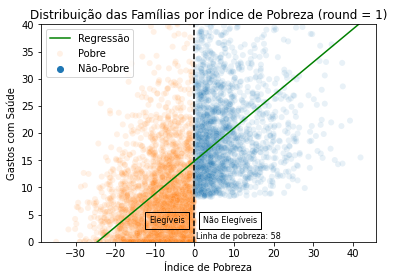

In [209]:
# objeto gráfico

fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)

# pontos

sns.scatterplot(data=dfTratados1, x='poverty_index_norm', y='health_expenditures', hue='pobre', alpha=0.1)

# linha

sns.lineplot(data=dfTratados1, x='poverty_index_norm', y='previsoes_simples1', ci=None, color='green', legend=False)

# linha vertical pontilhada

plt.vlines(x=0, ymin=0, ymax=40, linestyles='dashed')

# títulos

plt.title("Distribuição das Famílias por Índice de Pobreza (round = 1)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Gastos com Saúde")

# anotações

plt.annotate("Elegíveis", xy=(-7, 3.5), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate("Não Elegíveis", xy=(9, 3.5), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(.5, 0.5), fontsize=8)

# legenda

plt.legend(title='', loc='upper left', labels=['Regressão', 'Pobre', 'Não-Pobre'])

# limitando o eixo y

plt.ylim(0, 40)